<h1><center><bold>Fraud detection</bold></center></h1>

### Objectives
1. Develop a predictive model that accurately estimates good loans (Loans which will be not defaulted or late payment) which can be shown to investers to invest their money.
2. Investigate the impact of various factors such as loan amount, debt to income ratio, interest rate, months since last deliquency.
3. Implement a loan selection strategy that response to maximize revenue of invester and customer satisfaction.

### Methodology
1. **Data Collection and Preprocessing**: Gather comprehensive datasets and preprocess them by handling missing values, encoding categorical variables, and normalizing numerical features.
2. **Feature Engineering**: Extract relevant features and potentially create new ones to enhance the predictive power of the model, considering factors such as demand patterns and supply availability.
3. **Model Selection**: Explore various machine learning algorithms, including regression and ensemble methods, to identify the optimal model for dynamic pricing prediction.
4. **Model dfing and Evaluation**: df the selected model on the preprocessed dataset and evaluate its performance using appropriate metrics such as Precision, recall and since we are working with financial domain I will include F1 Score .

### Project Structure

1. [**Loading Ingestion**](#first): Load the dataset from a file or source into a DataFrame for analysis.
2. [**Data Preprocessing**](#second): Handle any missing or erroneous data, perform data type conversions, and clean the dataset for further analysis.
3. [**Exploratory Data Analysis (EDA)**](#third): Explore the dataset to gain insights into its distribution, relationships, and patterns. Visualize key features and relationships between variables.
4. [**Feature Engineering**](#fourth): Create new features or transform existing ones to improve the predictive power of the model.
5. [**Data Splitting**](#fifth): Split the dfing dataset into features (x) and the target variable (y) to prepare for model dfing.
6. [**Model Training**](#sixth): Utilize machine learning algorithms to df a predictive model on the dfing data.
7. [**Model Evaluation**](#seventh): Evaluate the dfed model's performance using appropriate metrics and techniques.
8. [**Summary**](#eighth): Summary and future scope of the project
9. [**References**](#ninth): References, websites which I have used to complete this project

### Libraries

In [1]:
import os

# Ignore Warnings
import warnings

#data Manipulations
import pandas as pd
import numpy as np
from scipy import stats

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.pandas

%matplotlib inline

# Data Transformation
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.preprocessing import StandardScaler

# Feature Selection
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# Pipeline
from sklearn.pipeline import Pipeline

# Models/Algorithms
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Metrics
import math
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, auc,
    ConfusionMatrixDisplay, RocCurveDisplay
)
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

from tqdm import tqdm

warnings.filterwarnings('ignore')  # Disabling warning outputs

# <a id='first'></a> Data Ingestion

In [2]:
### This function will goto specfic folder and read all csv files in our case *csv.gz files and 
### return as a Pandas data frame
def read_csvs_to_dataframe(folder_path, file_name = 'fraudTrain.csv.zip'):
    df = pd.read_csv(os.path.join(folder_path + file_name), compression='zip', index_col=0)
    return df

In [3]:
path = %pwd
folder_path = os.path.join(path, "data/")
file_name = 'fraudTrain.csv.zip'

df = read_csvs_to_dataframe(folder_path, file_name)

if not df.empty:
    print(f'Shape of the data is : {df.shape}')
else:
    print("No data to display.")

Shape of the data is : (1296675, 22)


### Total we have 1296675 rows and 22 columns in this dataset

# <a id='second'></a> Data Preprocessing

In [4]:
# Initialize empty lists to store object and non-object columns
obj = []
ints = []

# Loop through DataFrame columns
for col in df.columns:
    # Check if column data type is object
    if df[col].dtype == 'object':
        # If object, append column name, unique values count, and count of missing values to 'obj' list
        obj.append((col, df[col].nunique(), df[col].isna().sum()))
    else:
        # If non-object, append column name, unique values count, and count of missing values to 'ints' list
        ints.append((col, df[col].nunique(), df[col].isna().sum(), df[col].skew()))

# Determine the maximum length of 'obj' and 'ints' lists
max_len = max(len(obj), len(ints))

# Extend 'obj' and 'ints' lists with empty tuples to match the maximum length
obj.extend([('', '', '')] * (max_len - len(obj)))
ints.extend([('', '', '', '')] * (max_len - len(ints)))

# Create a dictionary with keys representing column categories and values representing lists of corresponding data
data = {
    'Categorical_columns': [x[0] for x in obj],
    'cat_cols_uniques': [x[1] for x in obj],
    'cat_cols_missing': [x[2] for x in obj],
    'Numeric_columns': [x[0] for x in ints],
    'int_cols_uniques': [x[1] for x in ints],
    'int_cols_missing': [x[2] for x in ints],
    'int_cols_skew': [x[3] for x in ints]
}

# Convert the dictionary into a pandas DataFrame
pd.DataFrame(data)

,Categorical_columns,cat_cols_uniques,cat_cols_missing,Numeric_columns,int_cols_uniques,int_cols_missing,int_cols_skew
0,trans_date_trans_time,1274791,0,cc_num,983,0,2.851879
1,merchant,693,0,amt,52928,0,42.277874
2,category,14,0,zip,970,0,0.079681
3,first,352,0,lat,968,0,-0.186028
4,last,481,0,long,969,0,-1.150108
5,gender,2,0,city_pop,879,0,5.593853
6,street,983,0,unix_time,1274823,0,0.003378
7,city,894,0,merch_lat,1247805,0,-0.181915
8,state,51,0,merch_long,1275745,0,-1.14696
9,job,494,0,is_fraud,2,0,13.029122


### We do not have any missing values in this dataset

In [5]:
df.head()
print('Below are the top 5 records of this dataset')

Below are the top 5 records of this dataset


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1296675 entries, 0 to 1296674
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   cc_num                 1296675 non-null  int64  
 2   merchant               1296675 non-null  object 
 3   category               1296675 non-null  object 
 4   amt                    1296675 non-null  float64
 5   first                  1296675 non-null  object 
 6   last                   1296675 non-null  object 
 7   gender                 1296675 non-null  object 
 8   street                 1296675 non-null  object 
 9   city                   1296675 non-null  object 
 10  state                  1296675 non-null  object 
 11  zip                    1296675 non-null  int64  
 12  lat                    1296675 non-null  float64
 13  long                   1296675 non-null  float64
 14  city_pop               

In [7]:
df.select_dtypes(include=['object']).head()

,trans_date_trans_time,merchant,category,first,last,gender,street,city,state,job,dob,trans_num
0,2019-01-01 00:00:18,"fraud_Rippin, Kub and Mann",misc_net,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9
1,2019-01-01 00:00:44,"fraud_Heller, Gutmann and Zieme",grocery_pos,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99
2,2019-01-01 00:00:51,fraud_Lind-Buckridge,entertainment,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95
3,2019-01-01 00:01:16,"fraud_Kutch, Hermiston and Farrell",gas_transport,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81
4,2019-01-01 00:03:06,fraud_Keeling-Crist,misc_pos,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46


# <a id='third'></a> Exploratory Data Analysis

In [8]:
print('Below will show total numbers for non-fraud transactions and total number of fraud transactions')
df['is_fraud'].value_counts().unique

Below will show total numbers for non-fraud transactions and total number of fraud transactions


<bound method Series.unique of is_fraud
0    1289169
1       7506
Name: count, dtype: int64>

In [9]:
### This will show us plot regarding fraud amounts
box_plot = df.hvplot.box(y='amt', by='is_fraud', title='Amount Distribution by Fraud Status', width=400, height=300)
box_plot

:BoxWhisker   [is_fraud]   (amt)

In [10]:
### For Explorations, we are workign only with fraud transactions
# Filter for fraudulent transactions
fraud_df_filtered = df[df['is_fraud'] == 1]

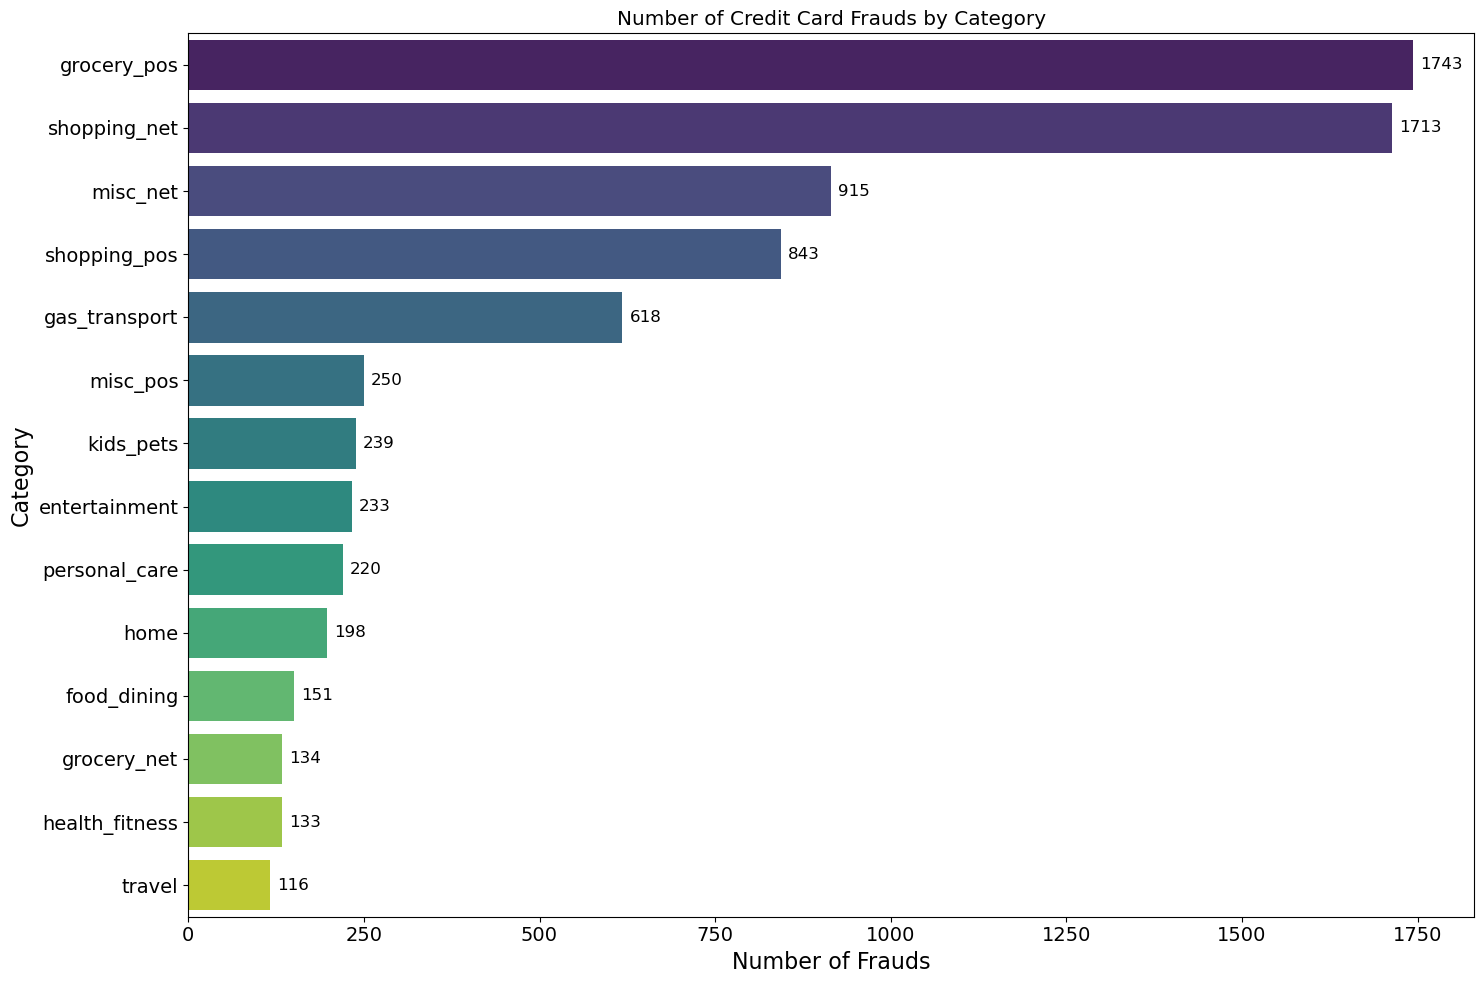

In [11]:
# Get the order for the categories (highest count first)
ordered_categories = fraud_df_filtered['category'].value_counts().index

fig, ax = plt.subplots(figsize=(15, 10))
plt.rcParams.update({'font.size': 12}) # Set a reasonable default font size

# Plot the countplot
sns.countplot(y='category', data=fraud_df_filtered, order=ordered_categories, ax=ax, palette='viridis')

plt.xticks(rotation=0) # Removed rotation for x-axis as it's now counts, usually not rotated
plt.title("Number of Credit Card Frauds by Category")
plt.xlabel("Number of Frauds", fontsize=16)
plt.ylabel("Category", fontsize=16)

# Adjust tick label font sizes
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

# Get the actual counts in the same order as the bars for annotation
counts_for_annotation = fraud_df_filtered['category'].value_counts().loc[ordered_categories]

# Add annotations to the bars
for p, count in zip(ax.patches, counts_for_annotation):
    # For horizontal bars:
    # x-coordinate is the width of the bar (the count value)
    # y-coordinate is the center of the bar
    x_val = p.get_width()
    y_val = p.get_y() + p.get_height() / 2

    # Annotate with the count
    # xytext shifts the text a little bit to the right of the bar
    # ha='left' aligns the text to its left edge at x_val + offset
    # va='center' vertically centers the text on the bar
    ax.annotate(f'{int(count)}', (x_val, y_val),
                xytext=(5, 0), textcoords='offset points',
                ha='left', va='center', fontsize=12) # Use a reasonable font size for annotations

plt.tight_layout() # Adjust layout to prevent labels/title from overlapping
plt.show()

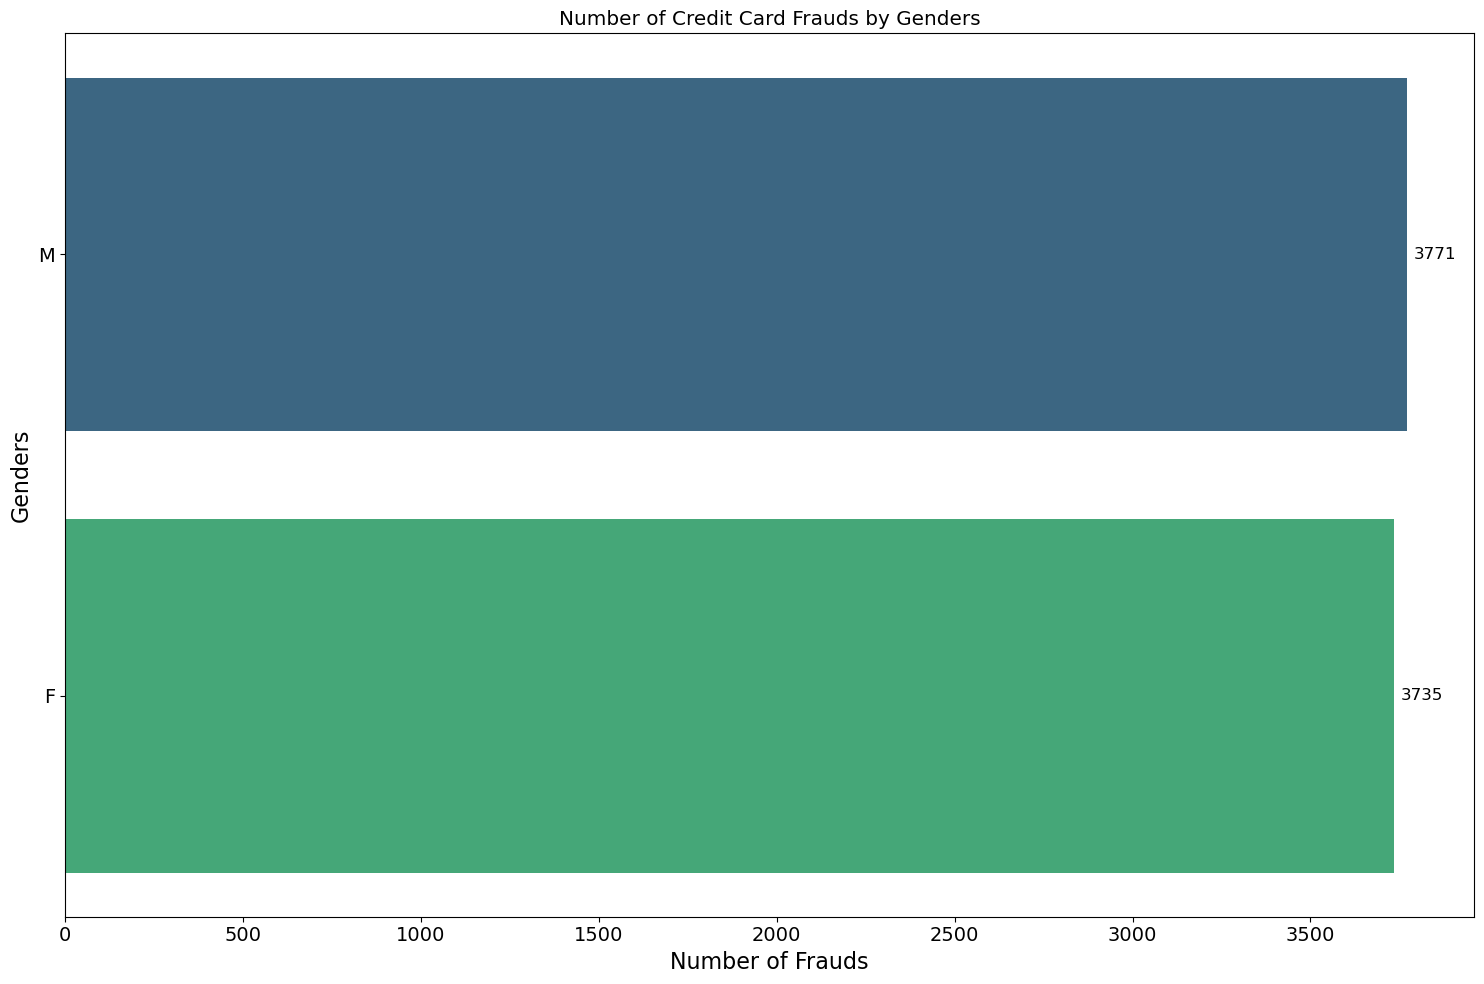

In [12]:
# Get the order for the categories (highest count first)
ordered_genders = fraud_df_filtered['gender'].value_counts().index

fig, ax = plt.subplots(figsize=(15, 10))
plt.rcParams.update({'font.size': 12}) # Set a reasonable default font size

# Plot the countplot
sns.countplot(y='gender', data=fraud_df_filtered, order=ordered_genders, ax=ax, palette='viridis')

plt.xticks(rotation=0) # Removed rotation for x-axis as it's now counts, usually not rotated
plt.title("Number of Credit Card Frauds by Genders")
plt.xlabel("Number of Frauds", fontsize=16)
plt.ylabel("Genders", fontsize=16)

# Adjust tick label font sizes
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

# Get the actual counts in the same order as the bars for annotation
counts_for_annotation = fraud_df_filtered['gender'].value_counts().loc[ordered_genders]

# Add annotations to the bars
for p, count in zip(ax.patches, counts_for_annotation):
    # For horizontal bars:
    # x-coordinate is the width of the bar (the count value)
    # y-coordinate is the center of the bar
    x_val = p.get_width()
    y_val = p.get_y() + p.get_height() / 2

    # Annotate with the count
    # xytext shifts the text a little bit to the right of the bar
    # ha='left' aligns the text to its left edge at x_val + offset
    # va='center' vertically centers the text on the bar
    ax.annotate(f'{int(count)}', (x_val, y_val),
                xytext=(5, 0), textcoords='offset points',
                ha='left', va='center', fontsize=12) # Use a reasonable font size for annotations

plt.tight_layout() # Adjust layout to prevent labels/title from overlapping
plt.show()

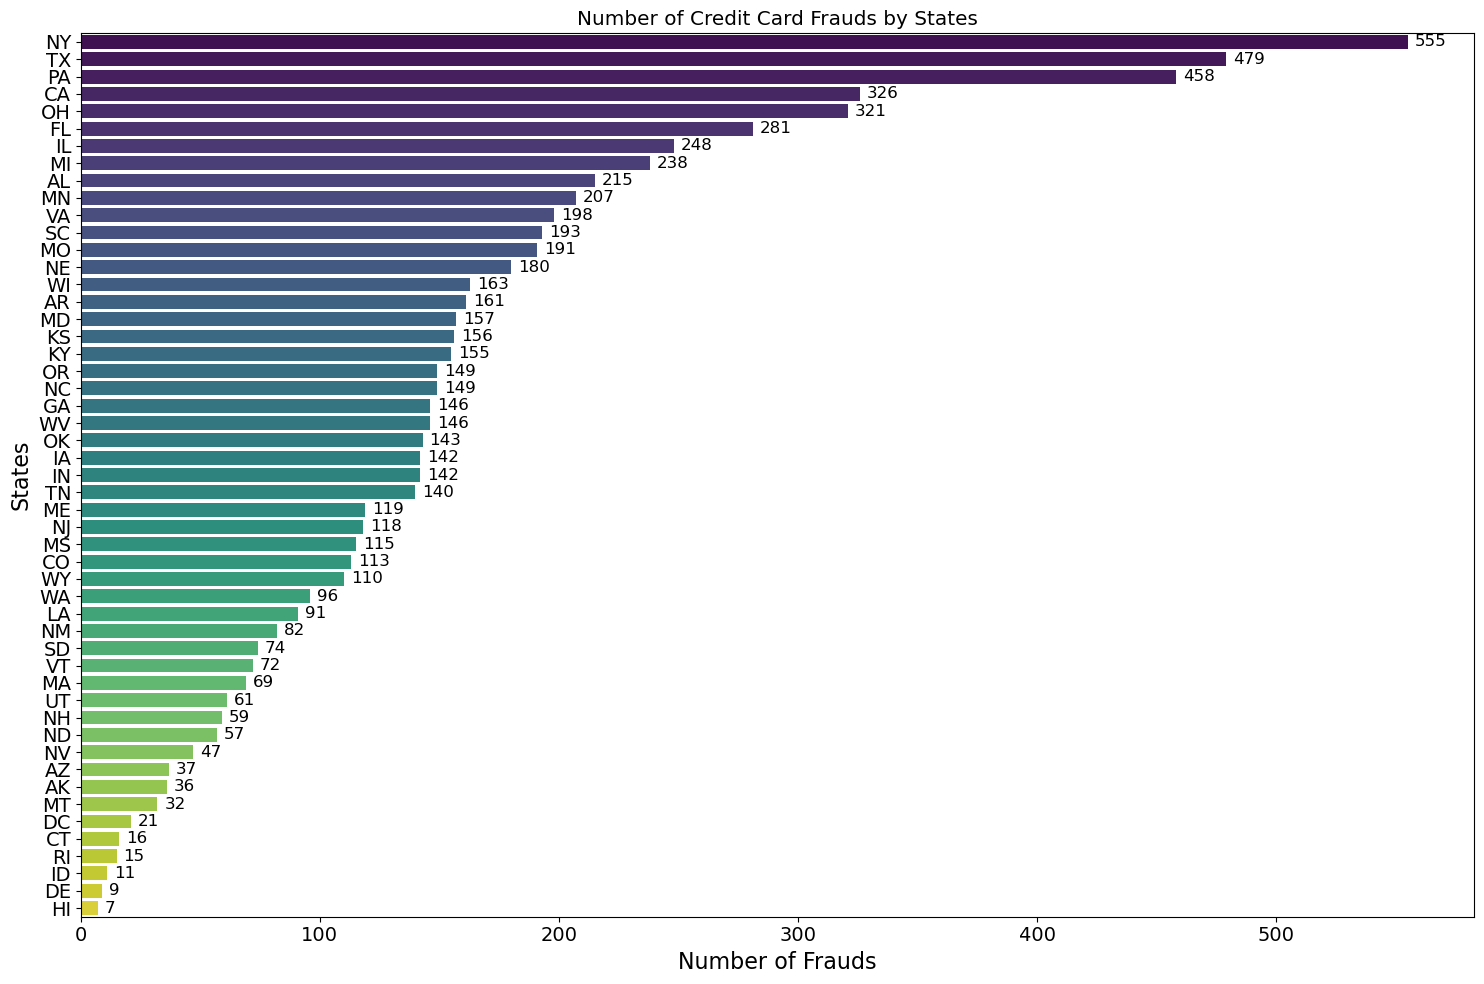

In [13]:
# Get the order for the categories (highest count first)
ordered_states = fraud_df_filtered['state'].value_counts().index

fig, ax = plt.subplots(figsize=(15, 10))
plt.rcParams.update({'font.size': 12}) # Set a reasonable default font size

# Plot the countplot
sns.countplot(y='state', data=fraud_df_filtered, order=ordered_states, ax=ax, palette='viridis')

plt.xticks(rotation=0) # Removed rotation for x-axis as it's now counts, usually not rotated
plt.title("Number of Credit Card Frauds by States")
plt.xlabel("Number of Frauds", fontsize=16)
plt.ylabel("States", fontsize=16)

# Adjust tick label font sizes
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

# Get the actual counts in the same order as the bars for annotation
counts_for_annotation = fraud_df_filtered['state'].value_counts().loc[ordered_states]

# Add annotations to the bars
for p, count in zip(ax.patches, counts_for_annotation):
    # For horizontal bars:
    # x-coordinate is the width of the bar (the count value)
    # y-coordinate is the center of the bar
    x_val = p.get_width()
    y_val = p.get_y() + p.get_height() / 2

    # Annotate with the count
    # xytext shifts the text a little bit to the right of the bar
    # ha='left' aligns the text to its left edge at x_val + offset
    # va='center' vertically centers the text on the bar
    ax.annotate(f'{int(count)}', (x_val, y_val),
                xytext=(5, 0), textcoords='offset points',
                ha='left', va='center', fontsize=12) # Use a reasonable font size for annotations

plt.tight_layout() # Adjust layout to prevent labels/title from overlapping
plt.show()

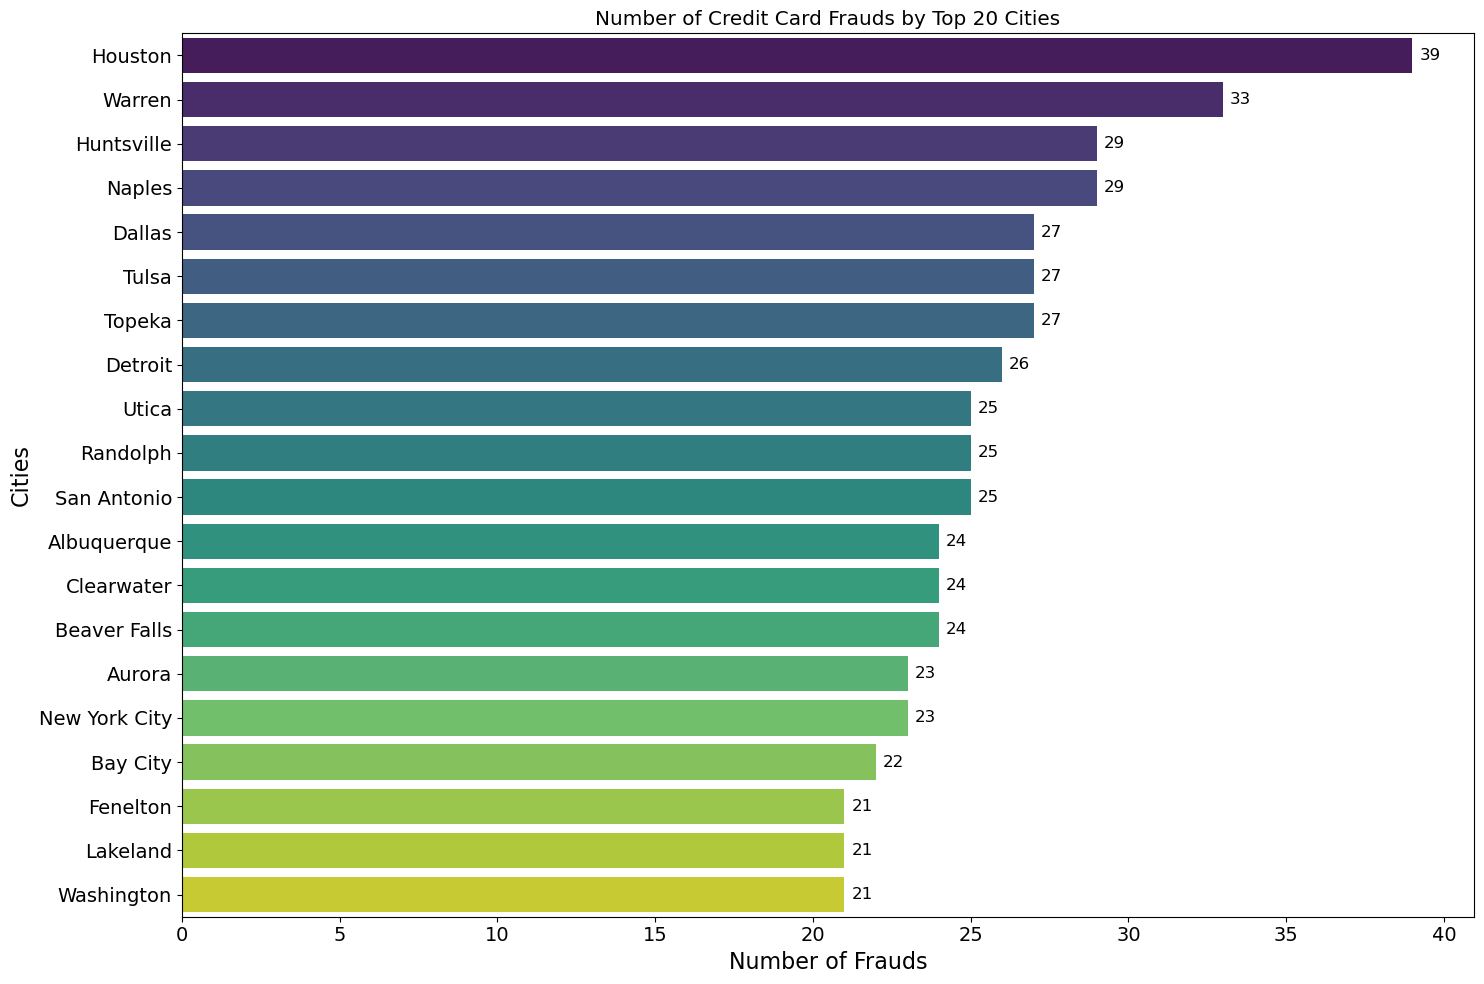

In [14]:
# Get the order for the categories (highest count first)
ordered_cities = fraud_df_filtered['city'].value_counts().head(20).index

fig, ax = plt.subplots(figsize=(15, 10))
plt.rcParams.update({'font.size': 12}) # Set a reasonable default font size

# Plot the countplot
sns.countplot(y='city', data=fraud_df_filtered, order=ordered_cities, ax=ax, palette='viridis')

plt.xticks(rotation=0) # Removed rotation for x-axis as it's now counts, usually not rotated
plt.title("Number of Credit Card Frauds by Top 20 Cities")
plt.xlabel("Number of Frauds", fontsize=16)
plt.ylabel("Cities", fontsize=16)

# Adjust tick label font sizes
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

# Get the actual counts in the same order as the bars for annotation
counts_for_annotation = fraud_df_filtered['city'].value_counts().loc[ordered_cities]

# Add annotations to the bars
for p, count in zip(ax.patches, counts_for_annotation):
    # For horizontal bars:
    # x-coordinate is the width of the bar (the count value)
    # y-coordinate is the center of the bar
    x_val = p.get_width()
    y_val = p.get_y() + p.get_height() / 2

    # Annotate with the count
    # xytext shifts the text a little bit to the right of the bar
    # ha='left' aligns the text to its left edge at x_val + offset
    # va='center' vertically centers the text on the bar
    ax.annotate(f'{int(count)}', (x_val, y_val),
                xytext=(5, 0), textcoords='offset points',
                ha='left', va='center', fontsize=12) # Use a reasonable font size for annotations

plt.tight_layout() # Adjust layout to prevent labels/title from overlapping
plt.show()

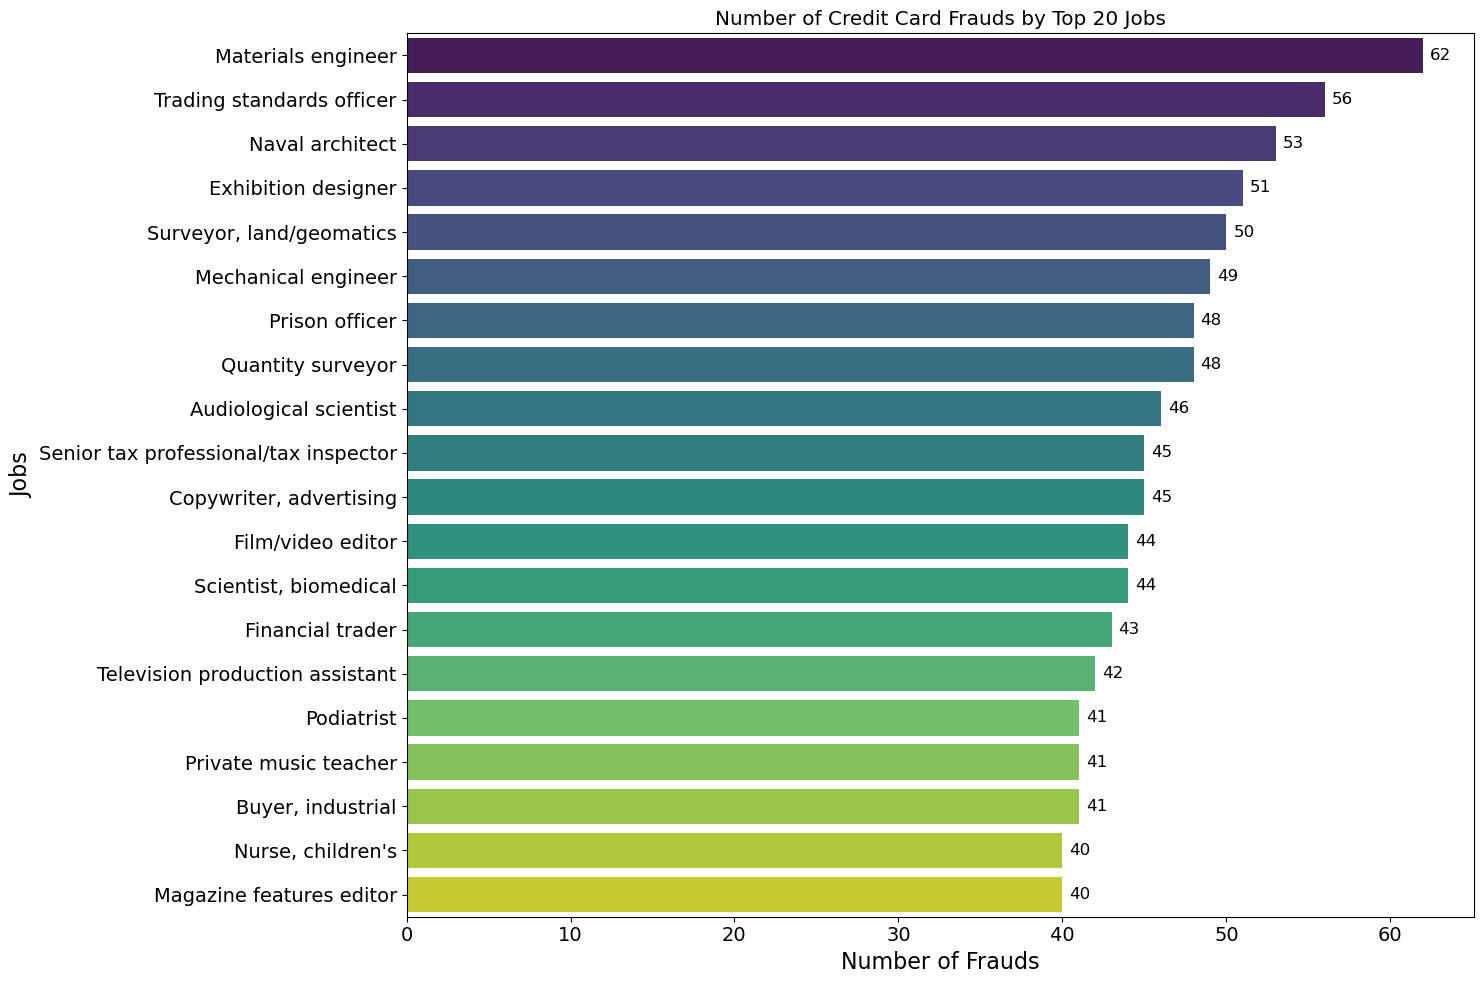

In [15]:
# Get the order for the categories (highest count first)
ordered_jobs = fraud_df_filtered['job'].value_counts().head(20).index

fig, ax = plt.subplots(figsize=(15, 10))
plt.rcParams.update({'font.size': 12}) # Set a reasonable default font size

# Plot the countplot
sns.countplot(y='job', data=fraud_df_filtered, order=ordered_jobs, ax=ax, palette='viridis')

plt.xticks(rotation=0) # Removed rotation for x-axis as it's now counts, usually not rotated
plt.title("Number of Credit Card Frauds by Top 20 Jobs")
plt.xlabel("Number of Frauds", fontsize=16)
plt.ylabel("Jobs", fontsize=16)

# Adjust tick label font sizes
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

# Get the actual counts in the same order as the bars for annotation
counts_for_annotation = fraud_df_filtered['job'].value_counts().loc[ordered_jobs]

# Add annotations to the bars
for p, count in zip(ax.patches, counts_for_annotation):
    # For horizontal bars:
    # x-coordinate is the width of the bar (the count value)
    # y-coordinate is the center of the bar
    x_val = p.get_width()
    y_val = p.get_y() + p.get_height() / 2

    # Annotate with the count
    # xytext shifts the text a little bit to the right of the bar
    # ha='left' aligns the text to its left edge at x_val + offset
    # va='center' vertically centers the text on the bar
    ax.annotate(f'{int(count)}', (x_val, y_val),
                xytext=(5, 0), textcoords='offset points',
                ha='left', va='center', fontsize=12) # Use a reasonable font size for annotations

plt.tight_layout() # Adjust layout to prevent labels/title from overlapping
plt.show()

In [16]:
### so far we have explored all the fraud transactions regarding, gender, state and city
### now we have to do some data transforamations and we will remove some of the columns which are not relavant

In [17]:
def drop_columns(df, columns_to_drop):
    df = df.drop(columns=columns_to_drop, axis=1)
    return df

In [18]:
columns_to_drop = ['cc_num','merchant','first','last','street','zip','trans_num','unix_time']
df = drop_columns(df, columns_to_drop)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1296675 entries, 0 to 1296674
Data columns (total 14 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   category               1296675 non-null  object 
 2   amt                    1296675 non-null  float64
 3   gender                 1296675 non-null  object 
 4   city                   1296675 non-null  object 
 5   state                  1296675 non-null  object 
 6   lat                    1296675 non-null  float64
 7   long                   1296675 non-null  float64
 8   city_pop               1296675 non-null  int64  
 9   job                    1296675 non-null  object 
 10  dob                    1296675 non-null  object 
 11  merch_lat              1296675 non-null  float64
 12  merch_long             1296675 non-null  float64
 13  is_fraud               1296675 non-null  int64  
dtypes: float64(5), int64(2)

In [19]:
### this function will do transformation of datetime

def transform_to_date(df):
    df['trans_date_trans_time']=pd.to_datetime(df['trans_date_trans_time'])
    df['trans_date']=df['trans_date_trans_time'].dt.strftime('%Y-%m-%d')
    df['trans_date']=pd.to_datetime(df['trans_date'])
    df['dob']=pd.to_datetime(df['dob'])
    return df


In [20]:
transform_to_date(df)
df.trans_date.head(),df.dob.head()

(0   2019-01-01
 1   2019-01-01
 2   2019-01-01
 3   2019-01-01
 4   2019-01-01
 Name: trans_date, dtype: datetime64[ns],
 0   1988-03-09
 1   1978-06-21
 2   1962-01-19
 3   1967-01-12
 4   1986-03-28
 Name: dob, dtype: datetime64[ns])

In [21]:
def generate_age_column(df):
    df["age"] = df["trans_date"]-df["dob"]
    df["age"]= np.floor(df["age"].dt.days / 365.25).astype(int)
    return df

In [22]:
generate_age_column(df)
df['age'].head()

0    30
1    40
2    56
3    51
4    32
Name: age, dtype: int32

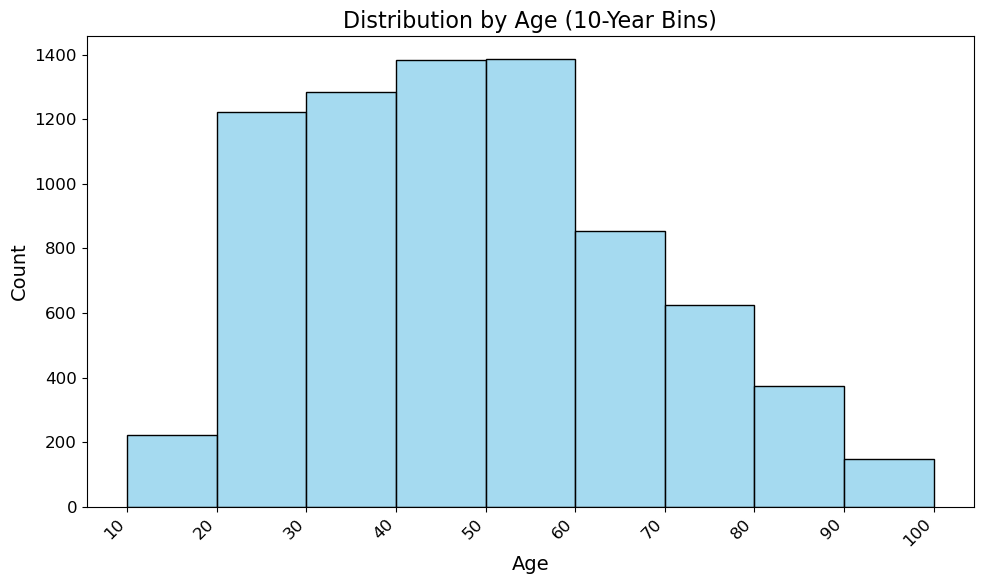

In [23]:
# If you want to plot 'age' only for fraudulent transactions:
data_to_plot = df[df["is_fraud"]==1]['age']

# --- Start of Seaborn Histogram Code ---

# Calculate bin edges based on the data's range, ensuring 10-year intervals
# Adjust 'data_to_plot' to your specific column/filtered data
min_val = data_to_plot.min()
max_val = data_to_plot.max()

# Round down start to nearest 10, round up end to nearest 10
bin_start = int(min_val // 10) * 10
bin_end = int(np.ceil(max_val / 10)) * 10

# Create bin edges with 10-year intervals
bins = np.arange(bin_start, bin_end + 10, 10)

fig, ax = plt.subplots(figsize=(10, 6)) # Adjust figsize as needed

# Create the histogram using sns.histplot
# 'binrange' ensures only data within these bounds are plotted
sns.histplot(data=data_to_plot, bins=bins, binrange=(bin_start, bin_end),
             edgecolor='black', color='skyblue', ax=ax)

# Set x-axis ticks to align with the bin edges (10, 20, 30, ...)
ax.set_xticks(bins)
# Set x-axis tick labels to be the integer values of the bin edges
ax.set_xticklabels([str(int(b)) for b in bins], rotation=45, ha='right', fontsize=12)

# Set labels and title with smaller font sizes
ax.set_xlabel("Age", fontsize=14)
ax.set_ylabel("Count", fontsize=14)
ax.set_title("Distribution by Age (10-Year Bins)", fontsize=16)

# Adjust y-axis tick label font size
ax.tick_params(axis='y', labelsize=12)

plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

In [24]:
df.head()

,trans_date_trans_time,category,amt,gender,city,state,lat,long,city_pop,job,dob,merch_lat,merch_long,is_fraud,trans_date,age
0,2019-01-01 00:00:18,misc_net,4.97,F,Moravian Falls,NC,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,36.011293,-82.048315,0,2019-01-01,30
1,2019-01-01 00:00:44,grocery_pos,107.23,F,Orient,WA,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,49.159047,-118.186462,0,2019-01-01,40
2,2019-01-01 00:00:51,entertainment,220.11,M,Malad City,ID,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,43.150704,-112.154481,0,2019-01-01,56
3,2019-01-01 00:01:16,gas_transport,45.00,M,Boulder,MT,46.2306,-112.1138,1939,Patent attorney,1967-01-12,47.034331,-112.561071,0,2019-01-01,51
4,2019-01-01 00:03:06,misc_pos,41.96,M,Doe Hill,VA,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,38.674999,-78.632459,0,2019-01-01,32


In [25]:
df['trans_month'] = pd.DatetimeIndex(df['trans_date']).month
df['trans_year'] = pd.DatetimeIndex(df['trans_date']).year

In [26]:
df['trans_month'].head()


0    1
1    1
2    1
3    1
4    1
Name: trans_month, dtype: int32

In [27]:
import calendar
df['month_name'] = df['trans_month'].apply(lambda x: calendar.month_abbr[x])
df['month_name'].unique()

array(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep',
       'Oct', 'Nov', 'Dec'], dtype=object)

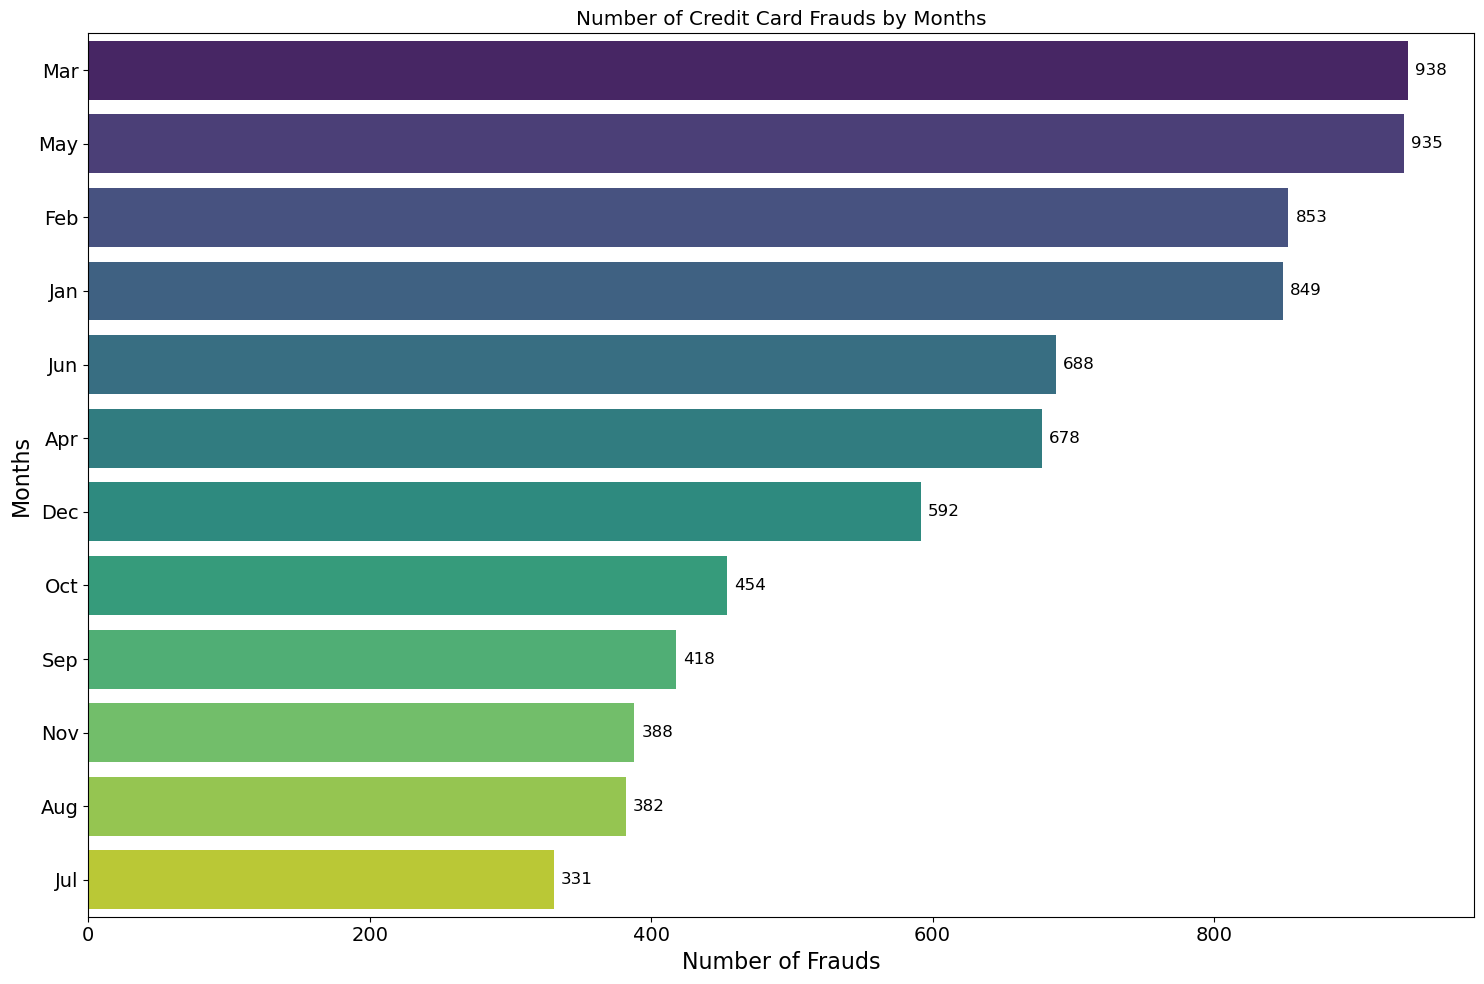

In [28]:
fraud_df_filtered = df[df['is_fraud']==1]
# Get the order for the categories (highest count first)
ordered_months = fraud_df_filtered['month_name'].value_counts().index

fig, ax = plt.subplots(figsize=(15, 10))
plt.rcParams.update({'font.size': 12}) # Set a reasonable default font size

# Plot the countplot
sns.countplot(y='month_name', data=fraud_df_filtered, order=ordered_months, ax=ax, palette='viridis')

plt.xticks(rotation=0) # Removed rotation for x-axis as it's now counts, usually not rotated
plt.title("Number of Credit Card Frauds by Months")
plt.xlabel("Number of Frauds", fontsize=16)
plt.ylabel("Months", fontsize=16)

# Adjust tick label font sizes
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

# Get the actual counts in the same order as the bars for annotation
counts_for_annotation = fraud_df_filtered['month_name'].value_counts().loc[ordered_months]

# Add annotations to the bars
for p, count in zip(ax.patches, counts_for_annotation):
    # For horizontal bars:
    # x-coordinate is the width of the bar (the count value)
    # y-coordinate is the center of the bar
    x_val = p.get_width()
    y_val = p.get_y() + p.get_height() / 2

    # Annotate with the count
    # xytext shifts the text a little bit to the right of the bar
    # ha='left' aligns the text to its left edge at x_val + offset
    # va='center' vertically centers the text on the bar
    ax.annotate(f'{int(count)}', (x_val, y_val),
                xytext=(5, 0), textcoords='offset points',
                ha='left', va='center', fontsize=12) # Use a reasonable font size for annotations

plt.tight_layout() # Adjust layout to prevent labels/title from overlapping
plt.show()

In [29]:
df['latitudinal_distance'] = abs(round(df['merch_lat']-df['lat'],4))
df['longitudinal_distance'] = abs(round(df['merch_long']-df['long'],4))

In [30]:
import random
def randomcolor():
    r = random.random()
    b = random.random()
    g = random.random()
    rgb = [r,g,b]
    return rgb


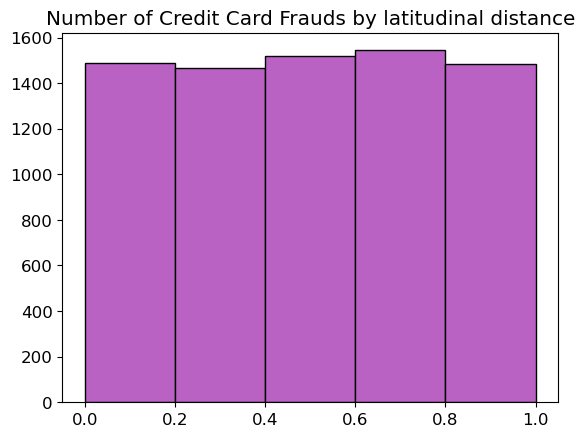

In [31]:
fraud = df[df["is_fraud"]==1]
fig, ax = plt.subplots()
ax.hist(fraud.latitudinal_distance, edgecolor = "black", bins = 5, color=randomcolor())
plt.title("Number of Credit Card Frauds by latitudinal distance")
plt.show()


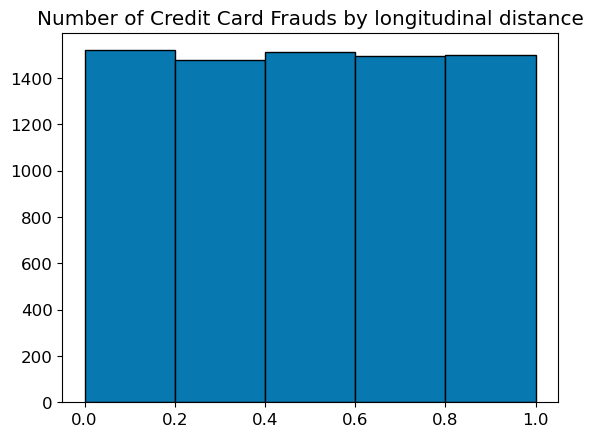

In [32]:
fig, ax = plt.subplots()
ax.hist(fraud.longitudinal_distance, edgecolor = "black", bins = 5, color=randomcolor())
plt.title("Number of Credit Card Frauds by longitudinal distance")
plt.show()


In [33]:
df.head()


,trans_date_trans_time,category,amt,gender,city,state,lat,long,city_pop,job,...,merch_lat,merch_long,is_fraud,trans_date,age,trans_month,trans_year,month_name,latitudinal_distance,longitudinal_distance
0,2019-01-01 00:00:18,misc_net,4.97,F,Moravian Falls,NC,36.0788,-81.1781,3495,"Psychologist, counselling",...,36.011293,-82.048315,0,2019-01-01,30,1,2019,Jan,0.0675,0.8702
1,2019-01-01 00:00:44,grocery_pos,107.23,F,Orient,WA,48.8878,-118.2105,149,Special educational needs teacher,...,49.159047,-118.186462,0,2019-01-01,40,1,2019,Jan,0.2712,0.0240
2,2019-01-01 00:00:51,entertainment,220.11,M,Malad City,ID,42.1808,-112.2620,4154,Nature conservation officer,...,43.150704,-112.154481,0,2019-01-01,56,1,2019,Jan,0.9699,0.1075
3,2019-01-01 00:01:16,gas_transport,45.00,M,Boulder,MT,46.2306,-112.1138,1939,Patent attorney,...,47.034331,-112.561071,0,2019-01-01,51,1,2019,Jan,0.8037,0.4473
4,2019-01-01 00:03:06,misc_pos,41.96,M,Doe Hill,VA,38.4207,-79.4629,99,Dance movement psychotherapist,...,38.674999,-78.632459,0,2019-01-01,32,1,2019,Jan,0.2543,0.8304


# <a id='fourth'></a> Feature Engineering